In [1]:
import altair as alt
import pandas as pd

import interactivede.ide as IDE # Our library

IDE.enable('altair') # Call this to enable integration with altair

Loaded InteractiveDE extension version 1.0.1a0
Extension enabled for altair


In [2]:
penguins_url = "https://raw.githubusercontent.com/vega/vega/master/docs/data/penguins.json"
pd.read_json(penguins_url)

,Species,Island,Beak Length (mm),Beak Depth (mm),Flipper Length (mm),Body Mass (g),Sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,None
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE
...,...,...,...,...,...,...,...
339,Gentoo,Biscoe,NaN,NaN,NaN,NaN,None
340,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,FEMALE
341,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,MALE
342,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,FEMALE


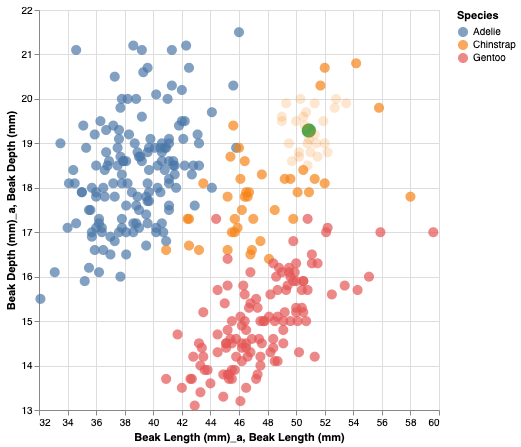

In [3]:
# All of the code here is pure altair. The library does not need any custom syntax

brush = alt.selection_interval(name='brush') # define a type of selection
# brush = alt.selection_interval(name='brush', encodings=['x']) # define a type of selection
# brush = alt.selection_interval(name='brush', encodings=['y']) # define a type of selection

# create a scatterplot
chart = alt.Chart(penguins_url).mark_circle().encode(
    x=alt.X('Beak Length (mm):Q', scale=alt.Scale(zero=False)),
    y=alt.Y('Beak Depth (mm):Q', scale=alt.Scale(zero=False)),
    color="Species:N",
    size=alt.value(100)
).properties(
    width=400,
    height=400
).add_selection(
    brush # Connect the brush selection to scatterplot
)

chart